In [32]:
signals = ['Open','NewOpen_1','NewOpen_2','NewOpen_3','NewClose_1','NewClose_2','NewClose_3','NewHigh_1','NewHigh_2','NewHigh_3','NewLow_1','NewLow_2','NewLow_3',"fast_ema","slow_ema","macd","signal"]
symbol = input("Enter the symbol : ")

Enter the symbol : INFY


In [11]:
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import json
import urllib
import pandas as pd
import concurrent
from concurrent.futures import ALL_COMPLETED

"""### Set Environment Variables """

HISTORICAL_DATA_URL = 'https://www.nseindia.com/api/historical/cm/equity?series=[%22EQ%22]&'
BASE_URL = 'https://www.nseindia.com/'

"""### Define Helper Functions """

def get_adjusted_headers():
    return {
        'Host': 'www.nseindia.com',
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:85.0) Gecko/20100101 Firefox/85.0',
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'X-Requested-With': 'XMLHttpRequest',
        'DNT': '1',
        'Connection': 'keep-alive',
    }

def fetch_cookies():
    response = requests.get(BASE_URL, timeout=30, headers=get_adjusted_headers())
    if response.status_code != requests.codes.ok:
        # logging.error("Fetched url: %s with status code: %s and response from server: %s" % (
        #     BASE_URL, response.status_code, response.content))
        raise ValueError("Please try again in a minute.")
    return response.cookies.get_dict()

def fetch_url(url, cookies):
    """
        This is the function call made by each thread. A get request is made for given start and end date, response is
        parsed and dataframe is returned
    """
    response = requests.get(url, timeout=30, headers=get_adjusted_headers(), cookies=cookies)
    if response.status_code == requests.codes.ok:
        json_response = json.loads(response.content)
        return pd.DataFrame.from_dict(json_response['data'])
    else:
        raise ValueError("Please try again in a minute.")

def scrape_data(start_date, end_date, name=None, input_type='stock'):
    """
    Called by stocks and indices to scrape data.
    Create threads for different requests, parses data, combines them and returns dataframe
    Args:
        start_date (datetime.datetime): start date
        end_date (datetime.datetime): end date
        input_type (str): Either 'stock' or 'index'
        name (str, optional): stock symbol or index name. Defaults to None.
    Returns:
        Pandas DataFrame: df containing data for stocksymbol for provided date range
    """
    cookies = fetch_cookies()

    start_date = datetime.strptime(start_date, "%d-%m-%Y")
    end_date = datetime.strptime(end_date, "%d-%m-%Y")

    threads, url_list = [], []

    # set the window size to one year
    window_size = timedelta(days=50)

    current_window_start = start_date
    while current_window_start < end_date:
        current_window_end = current_window_start + window_size

        # check if the current window extends beyond the end_date
        if current_window_end > end_date:
            current_window_end = end_date

        st = current_window_start.strftime('%d-%m-%Y')
        et = current_window_end.strftime('%d-%m-%Y')
        # print(st,et)
        if input_type == 'stock':
            params = {'symbol': name,
                        'from': st,
                        'to': et}
            url = HISTORICAL_DATA_URL + urllib.parse.urlencode(params)
            url_list.append(url)

        # move the window start to the next day after the current window end
        current_window_start = current_window_end + timedelta(days=1)

    result = pd.DataFrame()
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_to_url = {executor.submit(fetch_url, url, cookies): url for url in url_list}
        concurrent.futures.wait(future_to_url, return_when=ALL_COMPLETED)
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                df = future.result()
                result = pd.concat([result, df])
            except Exception as exc:
                # logging.error('%r generated an exception: %s. Please try again later.' % (url, exc))
                raise exc
    return format_dataframe_result(result, start_date, end_date)


def format_dataframe_result(result, start_date, end_date):
    if result.empty:
        return f"No Data Found : for date range {start_date} to {end_date}"
    columns_required = ["CH_TIMESTAMP", "CH_SYMBOL", "CH_SERIES", "CH_TRADE_HIGH_PRICE",
                        "CH_TRADE_LOW_PRICE", "CH_OPENING_PRICE", "CH_CLOSING_PRICE", "CH_LAST_TRADED_PRICE",
                        "CH_PREVIOUS_CLS_PRICE", "CH_TOT_TRADED_QTY", "CH_TOT_TRADED_VAL", "CH_52WEEK_HIGH_PRICE",
                        "CH_52WEEK_LOW_PRICE"]
    result = result[columns_required]
    result = result.set_axis(
        ['Date', 'Symbol', 'Series', 'High Price', 'Low Price', 'Open Price', 'Close Price', 'Last Price',
         'Prev Close Price', 'Total Traded Quantity', 'Total Traded Value', '52 Week High Price',
         '52 Week Low Price'], axis=1)
    result['Date'] = pd.to_datetime(result['Date'])
    result = result.sort_values('Date', ascending=True)
    result.reset_index(drop=True, inplace=True)
    return result

"""### Scrape Directly to DataFrame """


'### Scrape Directly to DataFrame '

In [22]:
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the MACD for a column in a pandas DataFrame using a sliding window approach.

    :param data: pandas DataFrame containing the data
    :param fast_period: number of periods for the fast EMA
    :param slow_period: number of periods for the slow EMA
    :param signal_period: number of periods for the signal line
    :return: pandas DataFrame with the MACD and signal line added as columns
    """
    # Calculate the fast and slow EMAs
    data['fast_ema'] = data['Close'].ewm(span=fast_period, adjust=False).mean()
    data['slow_ema'] = data['Close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate the MACD and signal line
    data['macd'] = data['fast_ema'] - data['slow_ema']
    data['signal'] = data['macd'].ewm(span=signal_period, adjust=False).mean()

    return data

In [7]:
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [12]:
today = datetime.now()
oneyearago = today - timedelta(days=365)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()

,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2022-05-31,SBIN,EQ,476.40,465.00,474.00,468.10,467.60,474.60,15441579,7.274762e+09,549.0,400.5
1,2022-06-01,SBIN,EQ,472.00,464.70,468.00,468.30,469.25,468.10,9424008,4.416955e+09,549.0,400.5
2,2022-06-02,SBIN,EQ,472.35,466.15,466.90,469.85,470.00,468.30,9370989,4.401384e+09,549.0,400.5
3,2022-06-03,SBIN,EQ,475.50,463.50,473.25,464.50,465.00,469.85,11306291,5.315646e+09,549.0,400.5
4,2022-06-06,SBIN,EQ,465.60,456.50,464.20,463.70,463.60,464.50,10661432,4.924334e+09,549.0,400.5


In [13]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price']]
df.columns = ['Date','High', 'Low', 'Open','Close']
df.head()

,Date,High,Low,Open,Close
0,2022-05-31,476.40,465.00,474.00,468.10
1,2022-06-01,472.00,464.70,468.00,468.30
2,2022-06-02,472.35,466.15,466.90,469.85
3,2022-06-03,475.50,463.50,473.25,464.50
4,2022-06-06,465.60,456.50,464.20,463.70


In [23]:
def make_data(df,name,n,col):
    for i in range(1,n+1):
        df[f"{name}_{i}"] = df[col].shift(+i)
    return df

make_data(df,"NewOpen",3,"Open")
make_data(df,"NewClose",3,"Close")
make_data(df,"NewHigh",3,"High")
make_data(df,"NewLow",3,"Low")
calculate_macd(df, 10, 26, 5)
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
3,2022-06-03,475.50,463.50,473.25,464.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,464.500000,464.500000,0.000000,0.000000
4,2022-06-06,465.60,456.50,464.20,463.70,473.25,NaN,NaN,464.5,NaN,...,475.50,NaN,NaN,463.5,NaN,NaN,464.354545,464.440741,-0.086195,-0.028732
5,2022-06-07,465.95,460.50,461.85,463.40,464.20,473.25,NaN,463.7,464.5,...,465.60,475.50,NaN,456.5,463.5,NaN,464.180992,464.363649,-0.182657,-0.080040
6,2022-06-08,475.55,463.20,466.60,471.30,461.85,464.20,473.25,463.4,463.7,...,465.95,465.60,475.5,460.5,456.5,463.5,465.475357,464.877453,0.597904,0.145941
7,2022-06-09,470.90,462.45,468.95,466.95,466.60,461.85,464.20,471.3,463.4,...,475.55,465.95,465.6,463.2,460.5,456.5,465.743474,465.030975,0.712499,0.334794


In [24]:
df = df.dropna()
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
6,2022-06-08,475.55,463.20,466.60,471.30,461.85,464.20,473.25,463.40,463.70,...,465.95,465.60,475.50,460.50,456.50,463.50,465.475357,464.877453,0.597904,0.145941
7,2022-06-09,470.90,462.45,468.95,466.95,466.60,461.85,464.20,471.30,463.40,...,475.55,465.95,465.60,463.20,460.50,456.50,465.743474,465.030975,0.712499,0.334794
8,2022-06-10,464.15,458.60,462.00,461.85,468.95,466.60,461.85,466.95,471.30,...,470.90,475.55,465.95,462.45,463.20,460.50,465.035569,464.795347,0.240223,0.303270
9,2022-06-13,454.05,442.10,454.00,445.85,462.00,468.95,466.60,461.85,466.95,...,464.15,470.90,475.55,458.60,462.45,463.20,461.547284,463.391988,-1.844704,-0.412721
10,2022-06-14,449.25,443.35,445.00,448.10,454.00,462.00,468.95,445.85,461.85,...,454.05,464.15,470.90,442.10,458.60,462.45,459.102323,462.259248,-3.156925,-1.327456


In [25]:
import numpy as np

def join_data(df, l):
    final_x = []
    for i in l:
        final_x.append(np.array(df[i]).reshape(-1,1))
        
    return np.concatenate(final_x,axis=1)

final_x = join_data(df, signals)
y = np.array(df["Close"]).reshape(-1,1)

In [26]:
drop = -40
X_train,X_test,y_train,y_test=final_x[:drop],final_x[drop:],y[:drop],y[drop:]

In [27]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.005)

In [28]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:544.80791	validation_1-rmse:558.88283
[100]	validation_0-rmse:332.23029	validation_1-rmse:339.83757
[200]	validation_0-rmse:202.83282	validation_1-rmse:205.59003
[300]	validation_0-rmse:123.98108	validation_1-rmse:126.07802
[400]	validation_0-rmse:75.93706	validation_1-rmse:78.05132
[500]	validation_0-rmse:46.71507	validation_1-rmse:48.73694
[600]	validation_0-rmse:29.01549	validation_1-rmse:30.76117
[700]	validation_0-rmse:18.38923	validation_1-rmse:19.96111
[800]	validation_0-rmse:12.13827	validation_1-rmse:13.52864
[900]	validation_0-rmse:8.59533	validation_1-rmse:9.87550
[999]	validation_0-rmse:6.70824	validation_1-rmse:7.93065


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

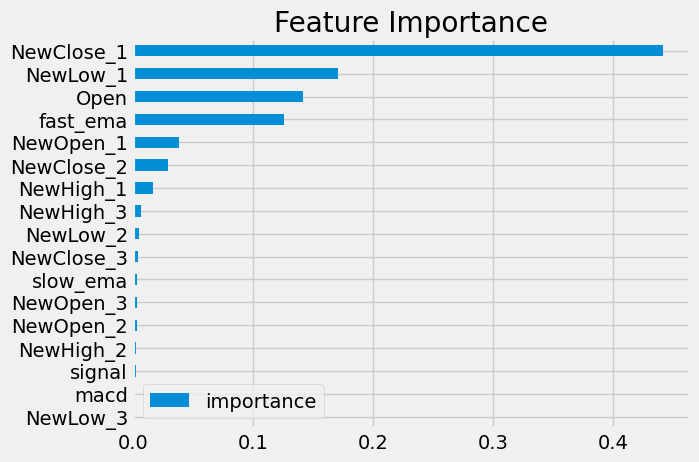

In [34]:
fi = pd.DataFrame(data=reg.feature_importances_,
             columns=['importance'],index=signals)
fi.sort_values('importance').plot.barh(title='Feature Importance')

plt.show()

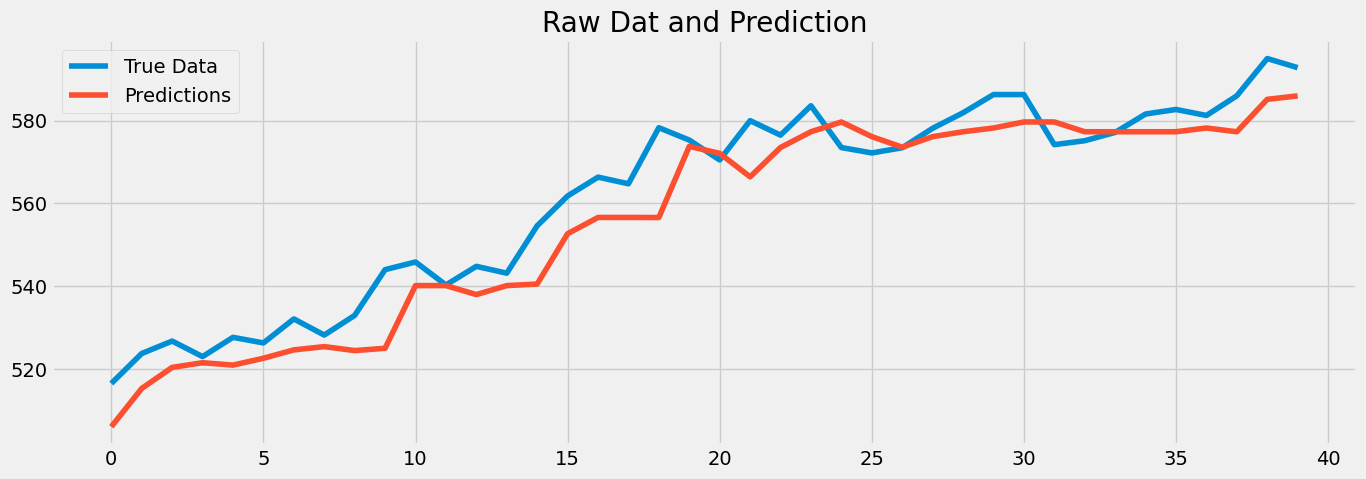

In [30]:
test = pd.DataFrame(y_test,columns=["Price"])
test['prediction'] = reg.predict(X_test)
ax = test["Price"].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='-')
plt.legend(['True Data','Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [31]:
df.tail()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
243,2023-05-24,585.25,578.25,579.80,582.70,578.90,577.50,579.0,581.60,577.15,...,583.70,580.30,586.25,576.80,573.45,569.90,578.798653,569.265411,9.533242,10.435013
244,2023-05-25,582.90,577.00,582.00,581.25,579.80,578.90,577.5,582.70,581.60,...,585.25,583.70,580.30,578.25,576.80,573.45,579.244352,570.153158,9.091194,9.987074
245,2023-05-26,587.75,580.55,581.25,586.00,582.00,579.80,578.9,581.25,582.70,...,582.90,585.25,583.70,577.00,578.25,576.80,580.472652,571.326999,9.145653,9.706600
246,2023-05-29,596.40,588.05,590.00,595.00,581.25,582.00,579.8,586.00,581.25,...,587.75,582.90,585.25,580.55,577.00,578.25,583.113988,573.080554,10.033434,9.815545
247,2023-05-30,595.50,591.50,595.00,592.80,590.00,581.25,582.0,595.00,586.00,...,596.40,587.75,582.90,588.05,580.55,577.00,584.875081,574.541254,10.333827,9.988306
